# Calling Libs

In [1]:
import math
import datetime
import numpy as np
import pandas as pd
import inflection
import matplotlib.pyplot as plt
plt.style.use('classic')
import matplotlib.gridspec as gridspec
import seaborn as sb; sb.set(style='whitegrid', font_scale=1.25, color_codes=True) 
import xgboost as xgb

%matplotlib inline

from scipy                 import stats  as ss
from IPython.core.display  import HTML
from IPython.display       import Image
from boruta                import BorutaPy

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor

In [2]:
df_sales_raw = pd.read_csv('train.csv', low_memory=False)
df_store_raw = pd.read_csv('store.csv', low_memory=False)

df_raw = pd.merge(df_sales_raw, df_store_raw,how='left', on='Store')

# i. Useful Functions

In [3]:
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print(f'\nKfold Number: {k}')
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date','sales'],axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date','sales'],axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining,ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    return pd.DataFrame({'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0])


# 1.0 Step 01 - Data Description

In [3]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [4]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase,cols_old))

df1.columns = cols_new

In [6]:
df1.head(30)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,5,2015-07-31,5651,589,1,1,0,1,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,5,2015-07-31,15344,1414,1,1,0,1,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,5,2015-07-31,8492,833,1,1,0,1,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,5,2015-07-31,8565,687,1,1,0,1,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,5,2015-07-31,7185,681,1,1,0,1,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN


In [7]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.3. Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.5. Fillout NA

In [9]:
'''competition_distance              2642 -> Distância entre uma loja e o concorrente mais próximo. 
Podemos assumir que um valor NaN nesta coluna pode representar que não há concorrente perto, 
ou o concorrente mais próximo pode estar tão longe que não vale ser computado. A distância máxima 
encontrada de um concorrente neste DF é de 75860.0 Km. Portanto podemos assumir hipoteticamente uma 
distância extremamente alta para substituir pelo valor nulo. Veja:
'''
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month    323348
'''Tanto aqui quanto na variável abaixo, vamos completar os valores NaN com os valores do mês e do ano
da venda daquela coluna em questão. Isso então nos diz que ao invés de um valor nulo, assume-se 
hipoteticamente que as vendas na concorrência começaram naquele momento, resultando em uma concorrÊncia 
de tempo nulo, mas contendo informação legível pela máquina.
'''
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year     323348
                                           
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
                                          
# promo2_since_week               508031
                                          
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)
                                
# promo2_since_year               508031
                                
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
                                
# # promo_interval                  508031

# month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# df1['promo_interval'].fillna(0,inplace=True)

# df1['month_map'] = df1['date'].dt.month.map(month_map)

# df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0 )

In [10]:
# promo_interval                  508031

month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0,inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1 )

In [11]:
df1.sample(5).T

,116651,577114,276385,873539,672682
store,692,330,880,165,8
day_of_week,6,4,3,4,2
date,2015-04-18 00:00:00,2014-01-30 00:00:00,2014-11-19 00:00:00,2013-05-09 00:00:00,2013-11-05 00:00:00
sales,3951,2879,6425,0,7629
customers,476,367,766,0,818
open,1,1,1,0,1
promo,0,0,0,0,1
state_holiday,0,0,0,a,0
school_holiday,0,0,0,0,0
store_type,a,a,a,a,a


In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
store                           1017209 non-null int64
day_of_week                     1017209 non-null int64
date                            1017209 non-null datetime64[ns]
sales                           1017209 non-null int64
customers                       1017209 non-null int64
open                            1017209 non-null int64
promo                           1017209 non-null int64
state_holiday                   1017209 non-null object
school_holiday                  1017209 non-null int64
store_type                      1017209 non-null object
assortment                      1017209 non-null object
competition_distance            1017209 non-null float64
competition_open_since_month    1017209 non-null float64
competition_open_since_year     1017209 non-null float64
promo2                          1017209 non-null int64
promo2_since_week               1017209 non-

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [16]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
competition_distance,1017209.0,5935.442677,12547.652996,20.0,710.0,2330.0,6910.0,200000.0
competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0


In [17]:
'''Primeiramente, vamos separar as variáveis numéricas das categóricas, ou de objetos.'''

num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64', 'datetime64[ns]'])

In [18]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
986345,0,d,c,"Feb,May,Aug,Nov",Jan
836844,0,a,a,"Jan,Apr,Jul,Oct",Jun


## 1.7.1. Numerical Attributes

In [19]:
# Central Tendency - mean, median;
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
# Dispersion - std, min, max,range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate 

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


## 1.7.2. Cattegorical Attributes

In [22]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

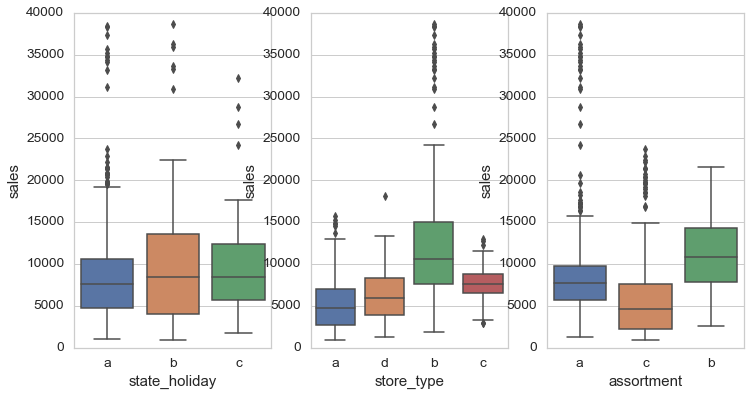

In [23]:
plt.figure(figsize = (12,6))
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales']> 0)]

plt.subplot(1,3,1)
sb.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sb.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sb.boxplot(x='assortment', y='sales', data=aux1)

# 2.0. Step 02 - Feature Engineering

In [24]:
df2 = df1.copy()

## 2.1. Hypothesis Mind Map

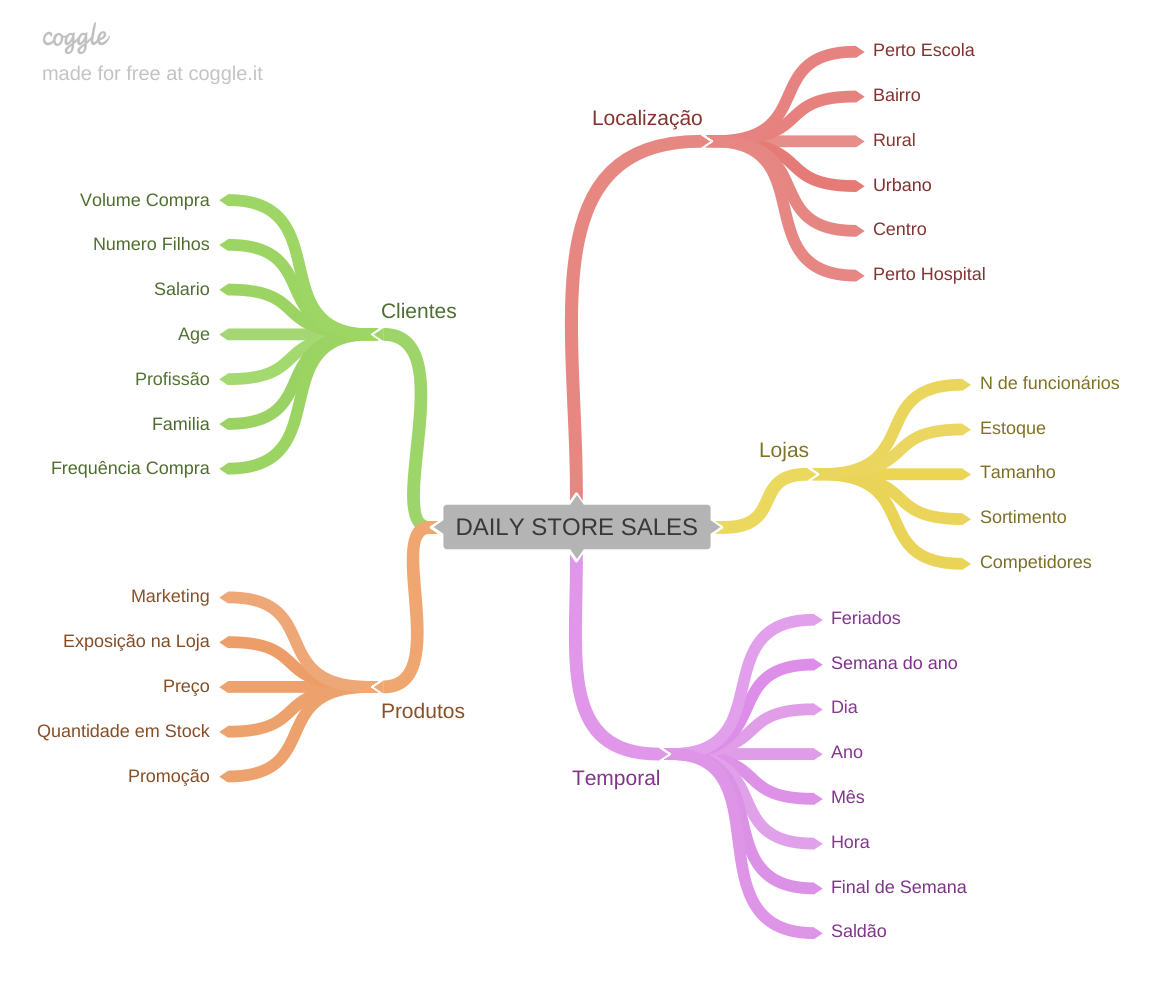

In [25]:
Image('MindMapHipothesis.png')

## 2.1. Criação das hipóteses

### 2.1.1. Hipótese Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.1.2. Hipótese Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Hipótese Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2. Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering

In [26]:
# Year
df2['year'] = df2['date'].dt.year

# Month
df2['month'] = df2['date'].dt.month

# Day
df2['day'] = df2['date'].dt.day

# Week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# Year Week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# Competition in promo since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# Promo Since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1','%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# Assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# State Holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


In [27]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. Step 03 - Variable Filtering

In [26]:
#df2.to_csv('df2_para_chamar_aqui.csv')

In [28]:
df3 = df2.copy()

In [29]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das Linhas

In [30]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das Colunas

In [31]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [32]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [33]:
#df3.to_csv('df3_to_call.csv', index=False)

# 4.0. Step 4 - Data Exploratory Analysis

In [3]:
#df3 = pd.read_csv('df3_to_call.csv')

In [4]:
df4 = df3.copy()

In [5]:
'''Aqui eu criei um novo conjunto de variáveis numéricas e categóricas, a partir do DF4,
ao invés de usar o já criado no DF1, como o Meigarom fez no curso.'''

num_attributes4 = df4.select_dtypes(include=['int64','float64'])
cat_attributes4 = df4.select_dtypes(exclude=['int64','float64', 'datetime64[ns]'])

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

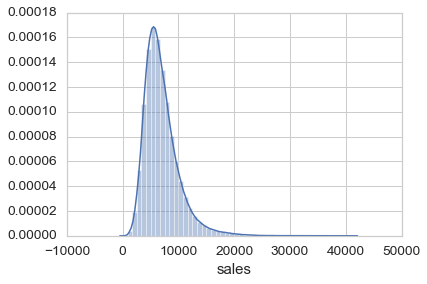

In [6]:
sb.distplot(df4['sales'])

### 4.1.2. Numerical Variable

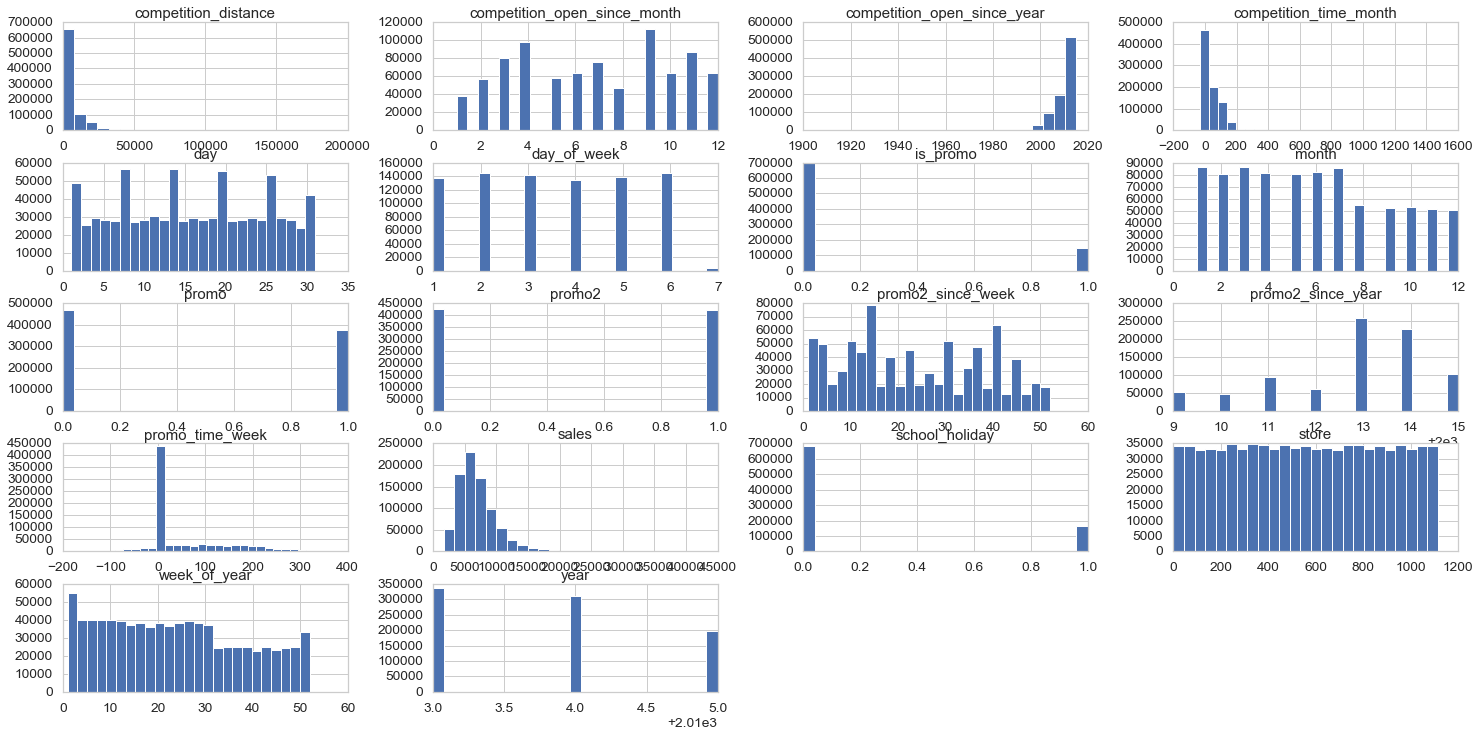

In [7]:
num_attributes4.hist(bins=25, figsize=(25, 12));

### 4.1.3. Categorical Variable

In [8]:
df4['state_holiday'].drop_duplicates()

0            regular_day
54837     public_holiday
107995    easter_holiday
199792         christmas
Name: state_holiday, dtype: object

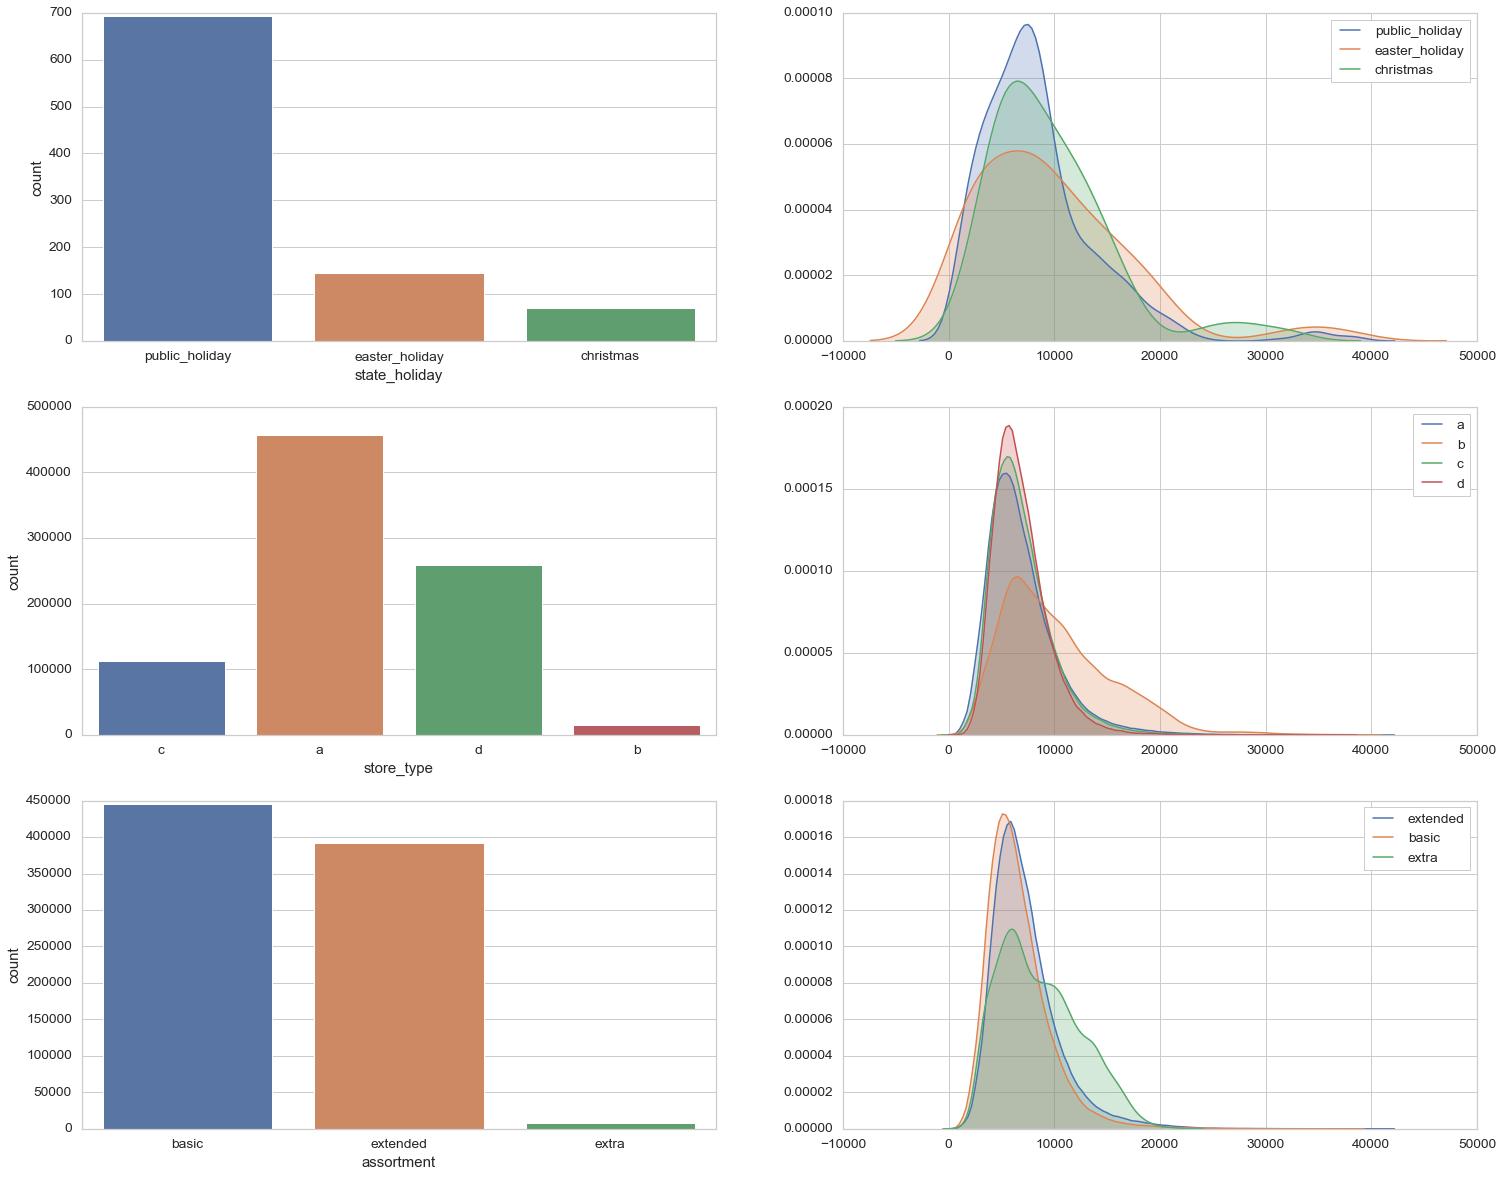

In [9]:
plt.figure(figsize=(25, 20))

plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sb.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sb.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sb.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sb.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot( 3, 2, 3 )
sb.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sb.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sb.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sb.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sb.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sb.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sb.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sb.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sb.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

## 4.2. Bivariate Analysis

### **H1.** Lojas com maior sortimentos deveriam vender mais.

**Verdadeiro** 

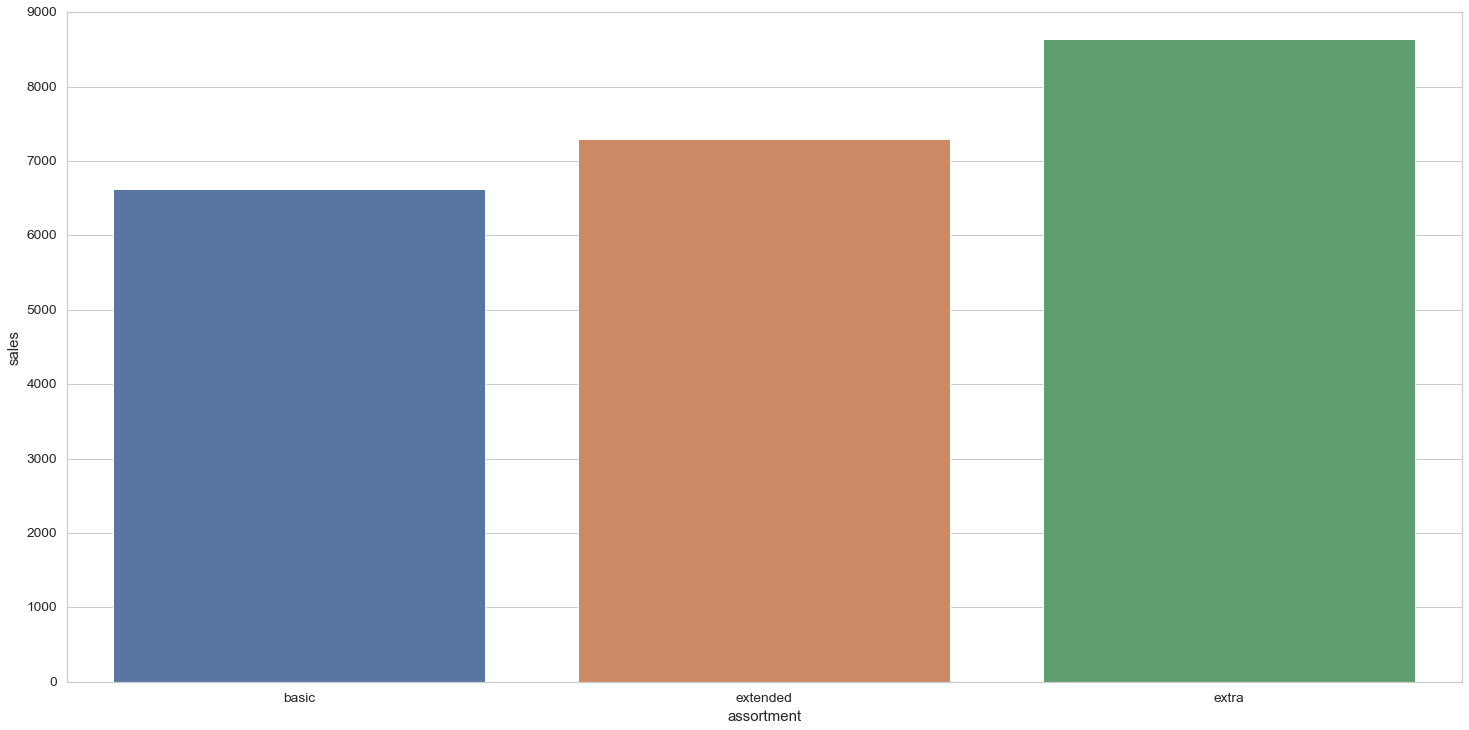

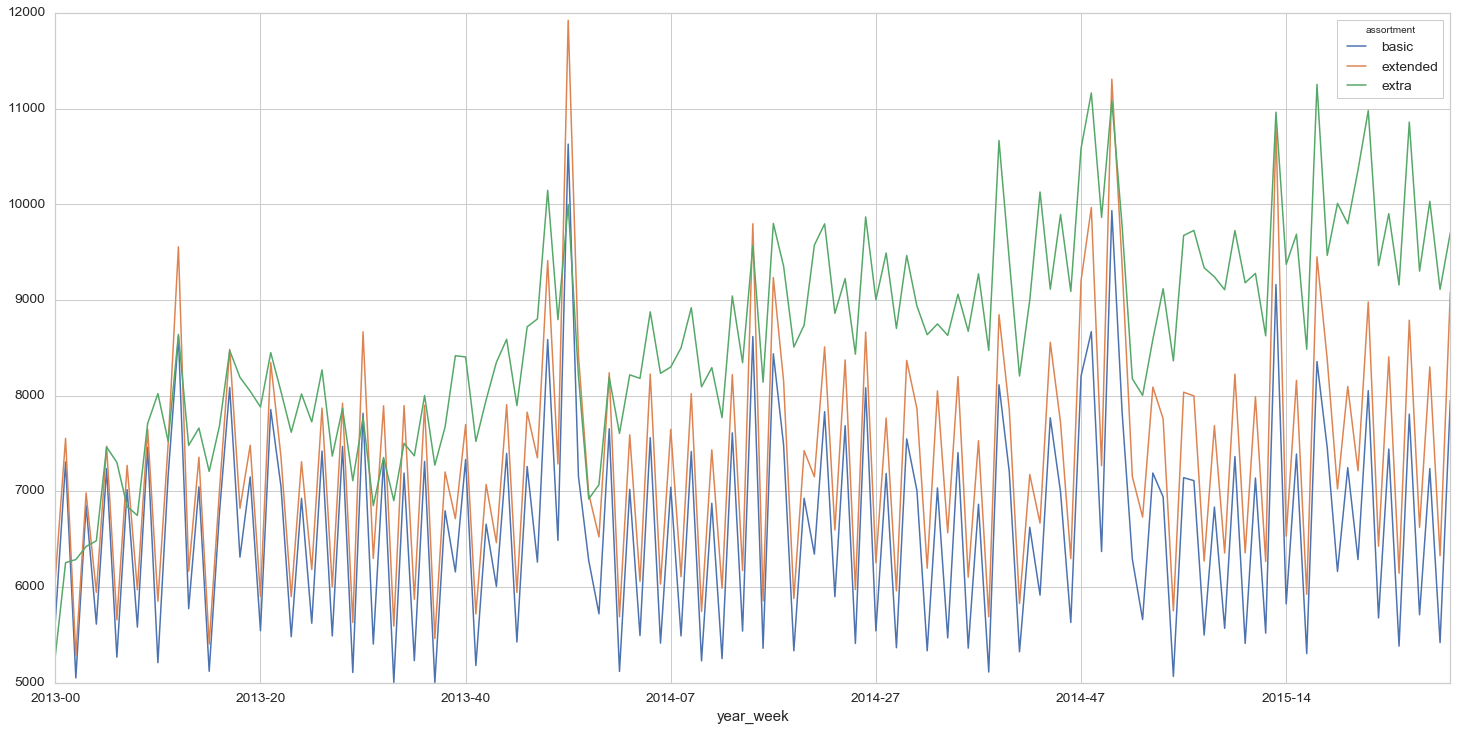

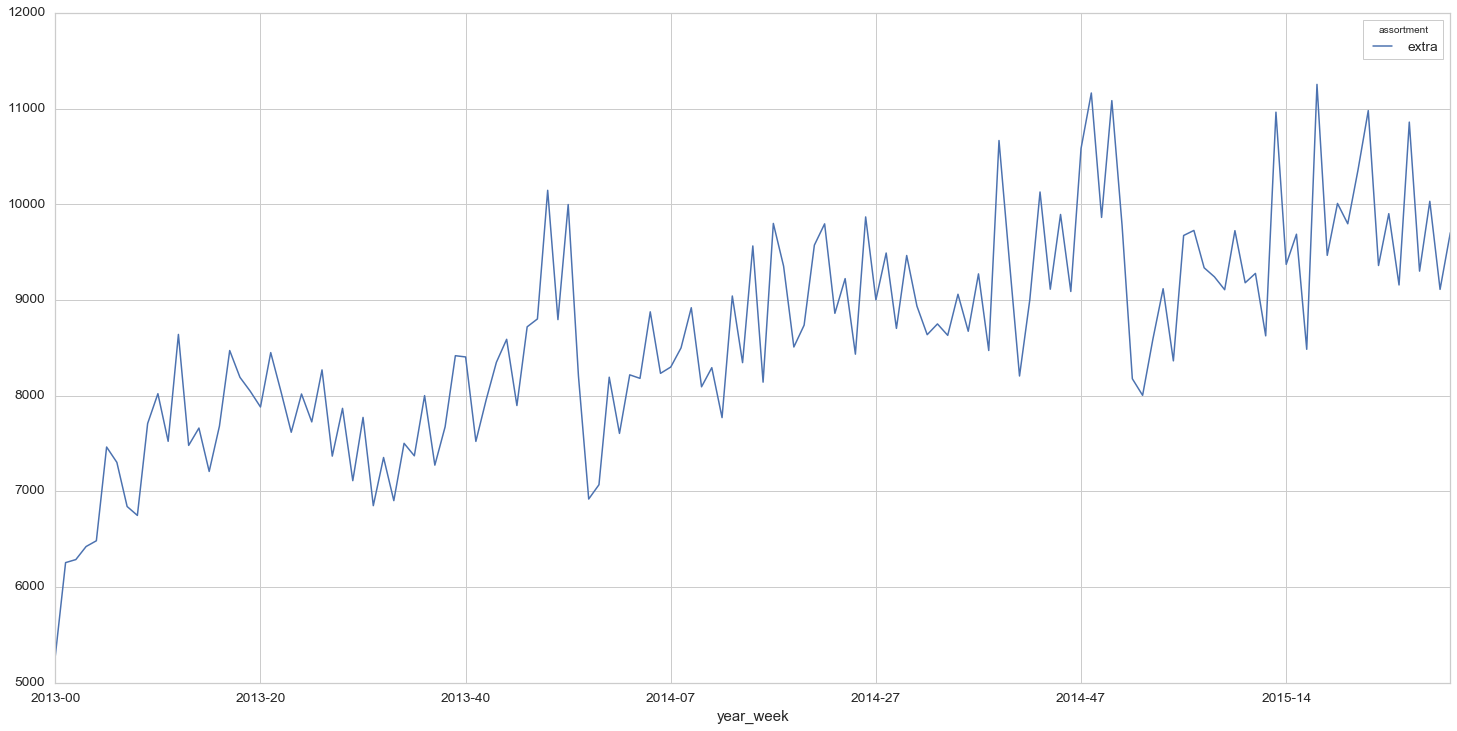

In [10]:
'''Aqui usa-se .mean() ao invés de .sum(), como o Meigarom fez no curso. Somar aqui não faz muito sentido.'''

plt.figure(figsize=(25, 12));
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sb.barplot(x = 'assortment',y = 'sales', data = aux1)

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).mean().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(25, 12));

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(25, 12));

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**Falsa**

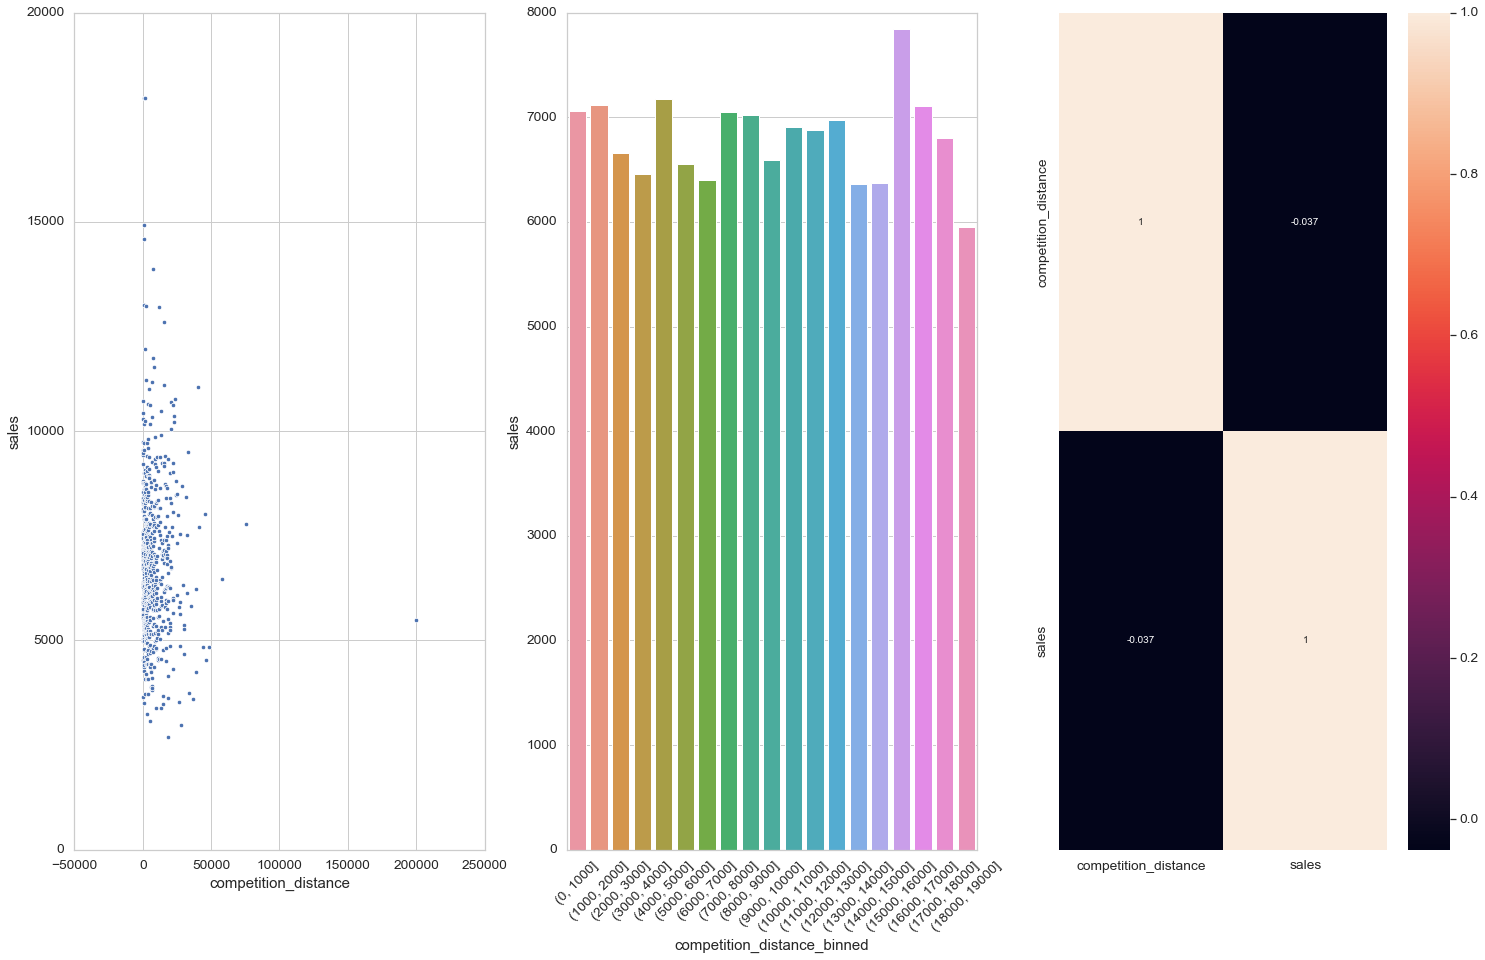

In [11]:
plt.figure(figsize=(25, 15));
aux4 = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

plt.subplot( 1, 3, 1 )
sb.scatterplot( x ='competition_distance', y='sales', data=aux4 );

plt.subplot( 1, 3, 2 )
bins = ( np.arange(0, 20000, 1000))
aux4['competition_distance_binned'] = pd.cut(aux4['competition_distance'], bins=bins)
aux5 = aux4[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').mean().reset_index()
sb.barplot(x = 'competition_distance_binned', y = 'sales', data = aux5);
plt.xticks(rotation=45);

plt.subplot( 1, 3, 3 )
x = sb.heatmap( aux4.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.
**Falsa**

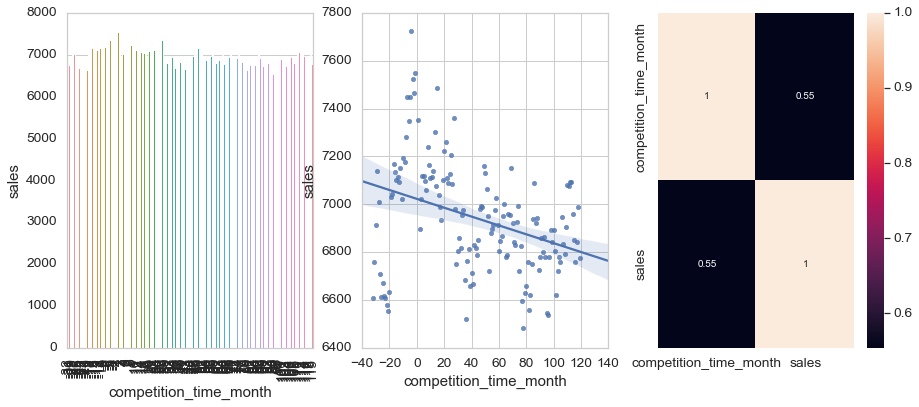

In [12]:
plt.figure(figsize=(15, 6));

plt.subplot(1, 3, 1);
aux6 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').mean().reset_index()
aux7 = aux6[(aux6['competition_time_month'] < 120) & (aux6['competition_time_month'] != 0)]
sb.barplot(x='competition_time_month', y='sales', data=aux7);
plt.xticks(rotation=90);

plt.subplot(1, 3, 2);
sb.regplot(x='competition_time_month', y='sales', data=aux7);

plt.subplot( 1, 3, 3 )
x = sb.heatmap( aux6.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**Falsa**

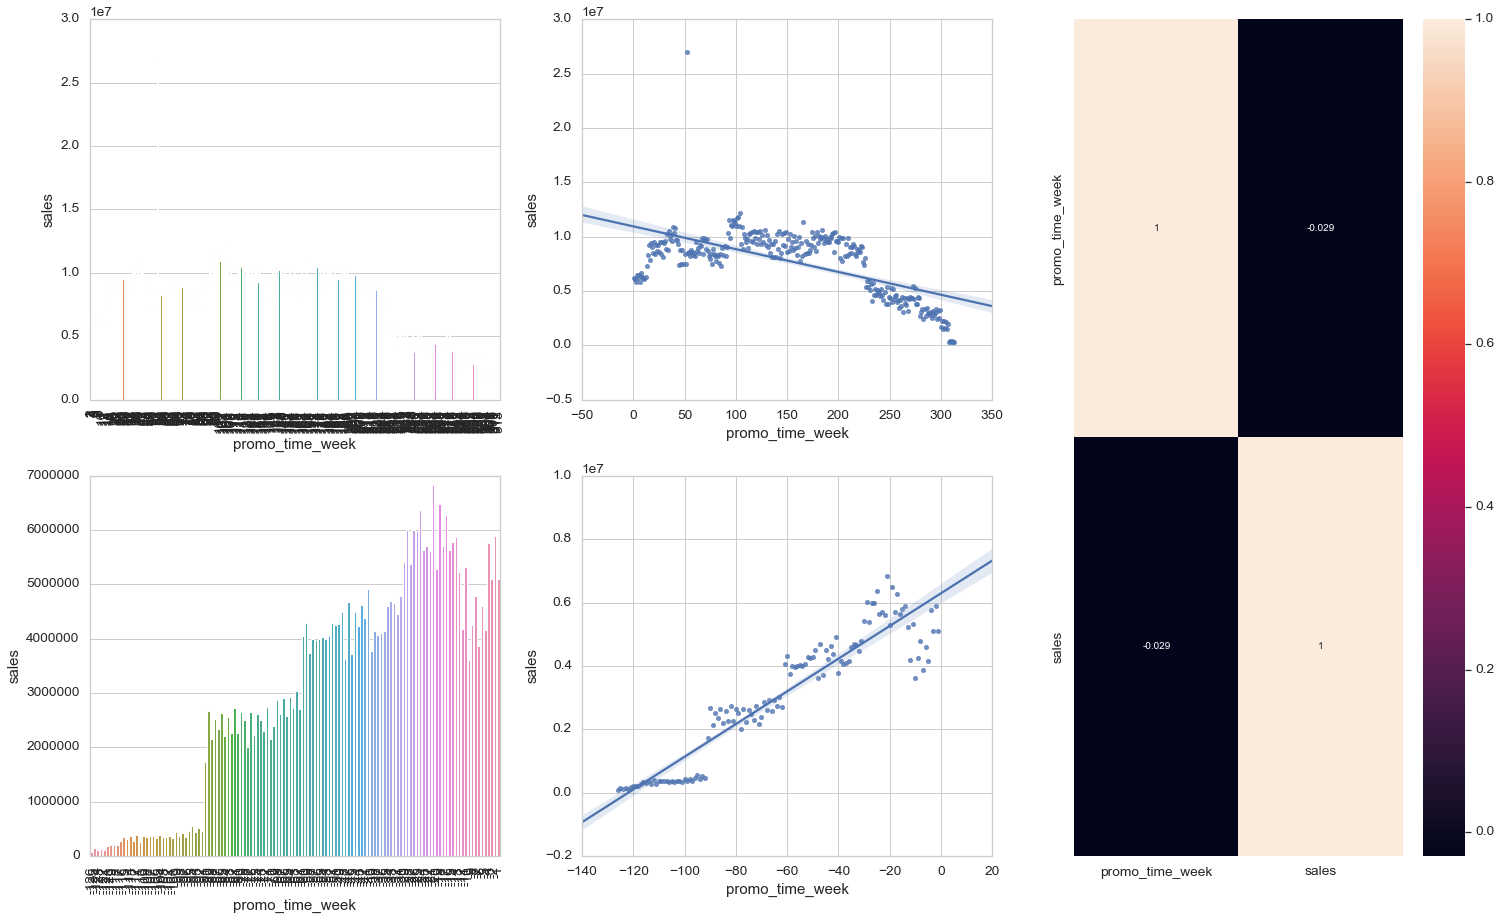

In [13]:
plt.figure(figsize=(25, 15));
aux8 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
#sb.barplot(x='promo_time_week', y='sales', data=aux8)

grid = gridspec.GridSpec(2,3)

plt.subplot( grid[0,0] )
aux9 = aux8[aux8['promo_time_week'] > 0] # promo extendida
sb.barplot(x='promo_time_week', y='sales', data=aux9);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sb.regplot(x='promo_time_week', y='sales', data=aux9);

plt.subplot(grid[1,0])
aux10 = aux8[aux8['promo_time_week'] < 0] # Promo regular
sb.barplot(x='promo_time_week', y='sales', data=aux10);
plt.xticks(rotation = 90);

plt.subplot(grid[1,1])
sb.regplot(x='promo_time_week', y='sales', data=aux10);

plt.subplot(grid[:,2])
x = sb.heatmap(aux8.corr(method='pearson'), annot=True)
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**Falsa**

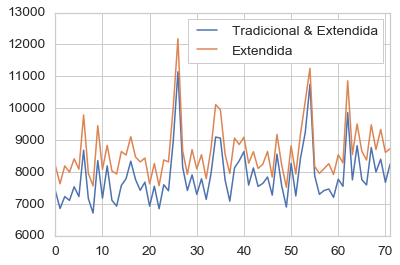

In [14]:
aux11 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).mean().reset_index()
ax = aux11.plot()

aux12 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).mean().reset_index()
aux12.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**Verdadeira, à princípio**

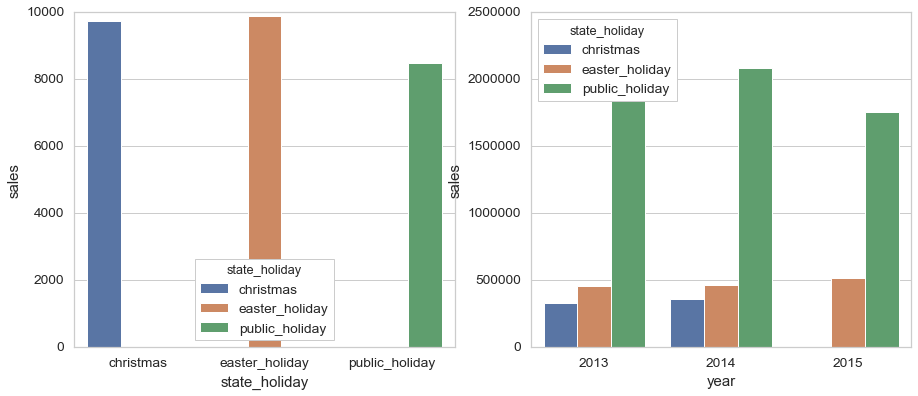

In [15]:
plt.figure(figsize=(15, 6));
aux13 = df4[df4['state_holiday']!='regular_day']

plt.subplot(1,2,1)
aux14 = aux13[['state_holiday','sales']].groupby('state_holiday').mean().reset_index()
sb.barplot(x='state_holiday', y='sales', hue='state_holiday', data=aux14);

plt.subplot(1,2,2)
aux15 = aux13[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sb.barplot(x='year',y='sales',hue='state_holiday',data=aux15)

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**Verdadeira**

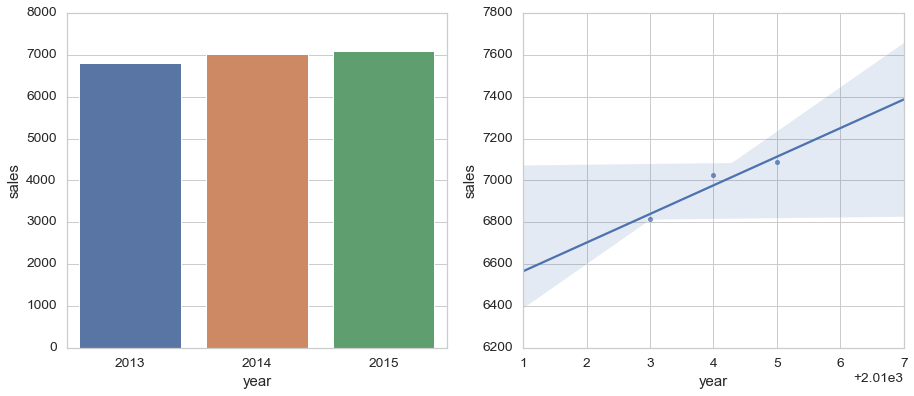

In [16]:
plt.figure(figsize=(15, 6));
aux16 = df4[['year','sales']].groupby('year').mean().reset_index()

plt.subplot(1, 2, 1)
sb.barplot(x='year',y='sales',data=aux16)

plt.subplot(1, 2, 2)
sb.regplot(x='year',y='sales',data=aux16)

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**Verdadeira, com ressalvas**

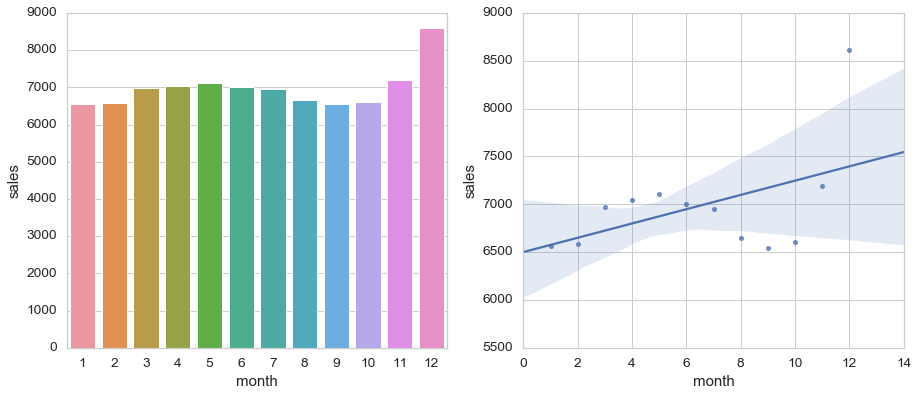

In [17]:
plt.figure(figsize=(15, 6));
aux17 = df4[['month','sales']].groupby('month').mean().reset_index()

plt.subplot(1, 2, 1)
sb.barplot(x='month',y='sales',data=aux17)

plt.subplot(1, 2, 2)
sb.regplot(x='month',y='sales',data=aux17)

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

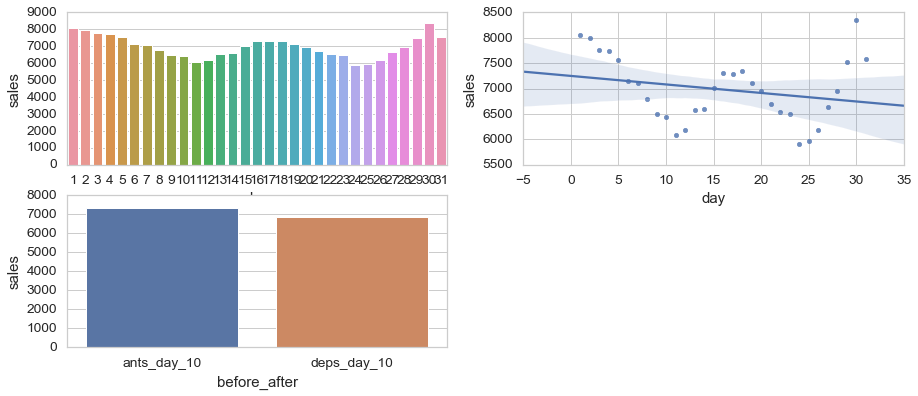

In [18]:
plt.figure(figsize=(15, 6));
aux18 = df4[['day','sales']].groupby('day').mean().reset_index()

plt.subplot(2, 2, 1)
sb.barplot(x='day',y='sales',data=aux18)

plt.subplot(2, 2, 2)
sb.regplot(x='day',y='sales',data=aux18)

aux18['before_after'] = aux18['day'].apply(lambda x: 'ants_day_10' if x <= 10 else 'deps_day_10')
aux19 = aux18[['before_after','sales']].groupby('before_after').mean().reset_index()

plt.subplot(2, 2, 3)
sb.barplot(x='before_after',y='sales',data=aux19)

### **H11.** Lojas deveriam vender menos aos finais de semana.
**Verdadeira**

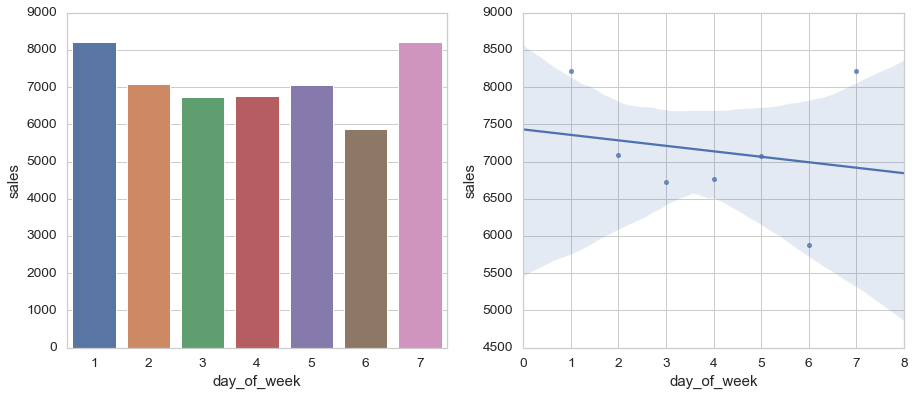

In [20]:
plt.figure(figsize=(15, 6));
aux20 = df4[['day_of_week','sales']].groupby('day_of_week').mean().reset_index()

plt.subplot(1, 2, 1)
sb.barplot(x='day_of_week',y='sales',data=aux20)

plt.subplot(1, 2, 2)
sb.regplot(x='day_of_week',y='sales',data=aux20)

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**Falsa** As lojas vendem MAIS. O que faz sentido quando as crianças estão em casa, pode-se fazer mais necessário recorrer à produtos de farmácia.

In [21]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

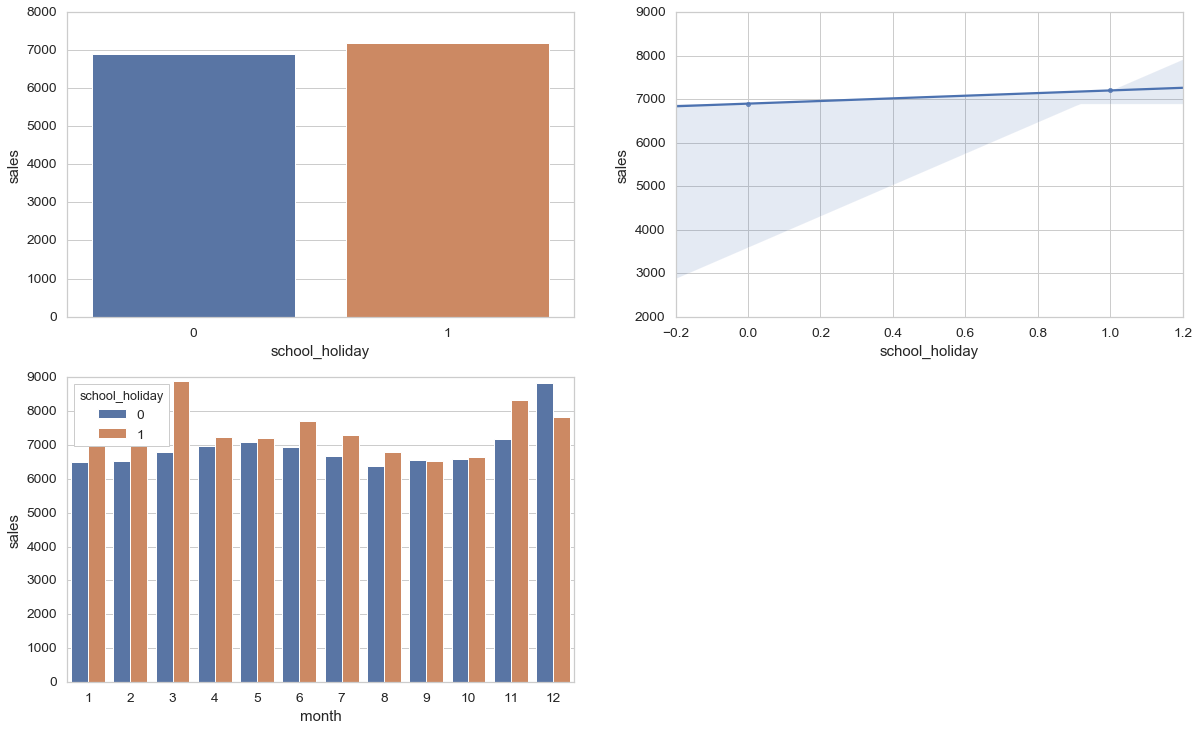

In [22]:
plt.figure(figsize=(20, 12));
aux20 = df4[['school_holiday','sales']].groupby('school_holiday').mean().reset_index()

plt.subplot(2, 2, 1)
sb.barplot(x='school_holiday',y='sales',data=aux20)

plt.subplot(2, 2, 2)
sb.regplot(x='school_holiday',y='sales',data=aux20)

aux21 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).mean().reset_index()

plt.subplot(2, 2, 3)
sb.barplot(x='month',y='sales',hue='school_holiday',data=aux21)

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

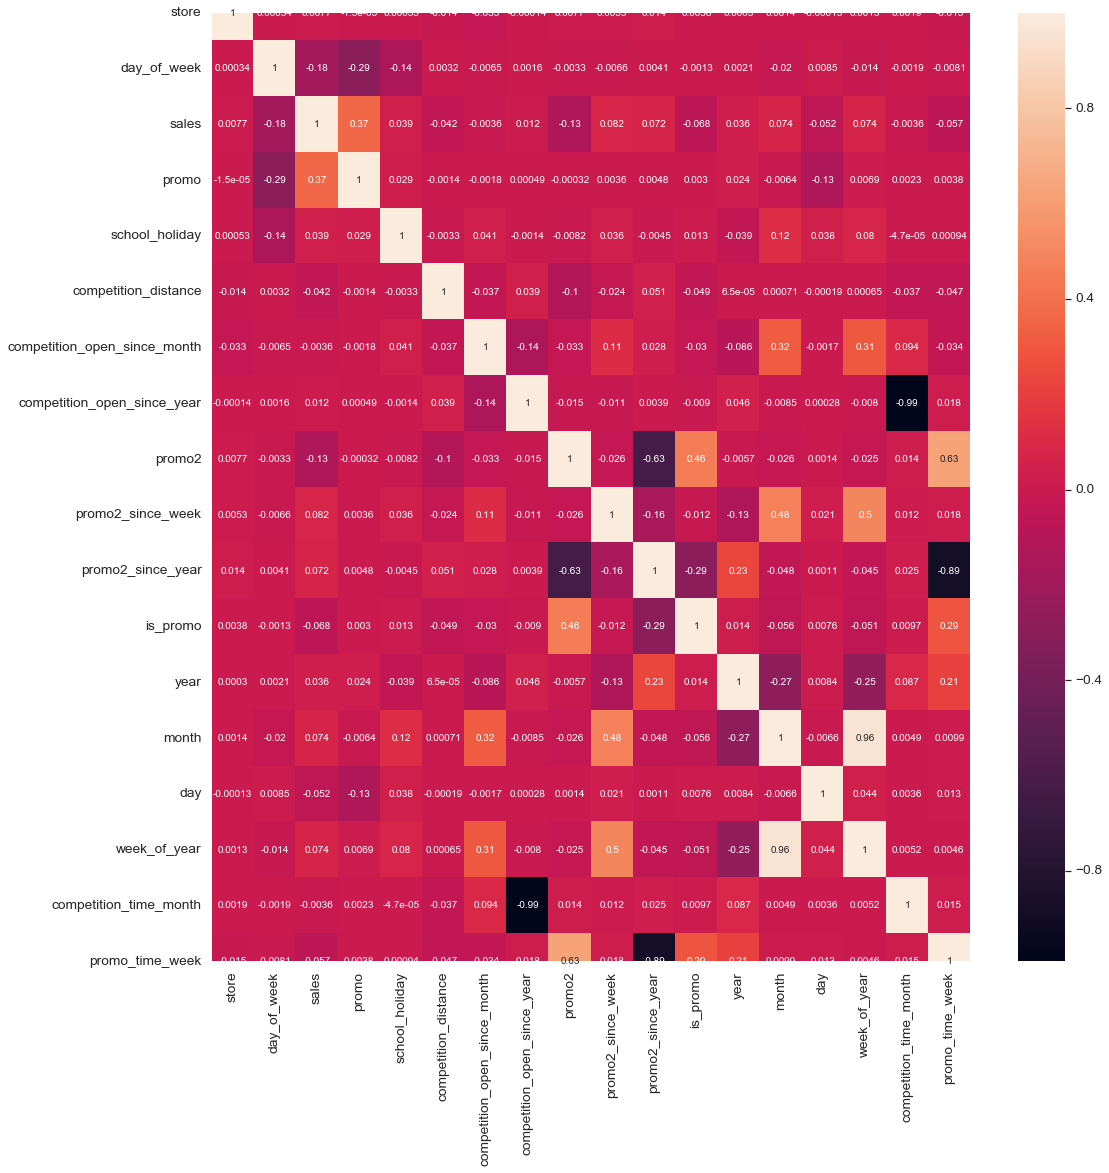

In [26]:
plt.figure(figsize=(17,17))
correlation = num_attributes4.corr(method='pearson')
sb.heatmap(correlation, annot=True)

In [27]:
# Definindo V de Cramer pra estudar correlação entre variáveis categóricas

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

C:\Users\Pena Arthorivs\.conda\envs\labns\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


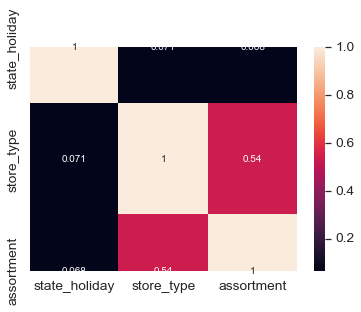

In [31]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sb.heatmap( d, annot=True )

# 5.0. Step 5 - Data Preparation

In [3]:
df4 = pd.read_csv('df4_to_call.csv')

## 5.1. Normalization

In [4]:
df5 = df4.copy()

**BR:** A Normalização foi deixada de lado por conta do comportamento encontrado na Análise Univariada do capítulo 04,
os dados aparentam estar bem distribuídos, no caso dos que é possível analisar a distribuição. Logo, a normalização não será
forçada, e vamos direto para o Rescaling.

## 5.2. Rescaling

**BR:** O método Robust Scaler é usado quando os dados possuem muitos outliers e/ou uqando estes outliers possuem uma ordem 
de grandeza muito discrepante da distribuição dos seus dados, normalmente se faz um boxplot, e a partir dele se interpreta 
qual o melhor método de escala dos dados. No nosso caso, o Robust scaler será aplicado como abaixo.

In [5]:
rs = RobustScaler()
mms = MinMaxScaler()

'''Competition distance: Lembra que ao fazermos o tratamento de dados faltantes a gente estimou distâncias exorbitantes? 
Pois é. Estes caras aqui estão representando Outliers, logo, o Robust Scaler é a melhor forma de tratá-los'''

df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# o mesmo para competition time month

df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# No caso de promo time week e Year, as features já podem ser normalmente distribuidas, lofo usaremos o escalador MinMax

df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year

df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3. Transforming


### 5.3.1. Encoding

In [6]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Response Variable Transformation

In [7]:
df5['sales'] = np.log1p(df5['sales'])

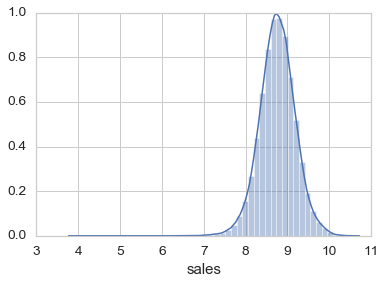

In [8]:
sb.distplot(df5['sales'])

### 5.3.3. Nature Transformation - Cyclic

In [9]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

In [10]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [11]:
#df5.to_csv('df5_to_call.csv', index=False)

# 6.0. Step 06 - Feature Selection

In [4]:
df5 = pd.read_csv('df5_to_call.csv')

In [5]:
df5['date'] = pd.to_datetime(df5['date'])

In [6]:
df6 = df5.copy()

## 6.1. Splitting dataframe into training and test datasets

In [7]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

-> Neste momento, vamos fazer algo de maneira estratégica, vamos pegar as seis **ULTIMAS** semanas do registro de vendas, e usá-las como dados de **TESTE**, sobrando como dados de **TREINO** todo o ataframe antes destas seis semanas. Logo, segue-se que:

In [7]:
date_reset = df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] 
#date_reset2 = datetime.datetime.strptime(date_reset, '%Y-%m-%d')
date_reset #- datetime.timedelta(days=6*7)

Timestamp('2015-07-31 00:00:00')

In [8]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [12]:
# Datasets for Boruta
X_train_n = X_train.drop(['date','sales'], axis=1).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# Defining Boruta - X_train_n e y_train_n são vetores agora, não dataframes, portanto não possuem nomes nas colunas mais.
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state = 42).fit(X_train_n,y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1. Best Features from Boruta

In [13]:
# support_ fornece números que ajudam a identificar a relevâcia das  features ditada pelo Boruta
cols_selected = boruta.support_.tolist()

# best features - selecionadas do X_train mesmo por que o _n não é mais dataframe.
X_train_fs = X_train.drop(['date', 'sales'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [9]:
cols_selected_boruta = ['store', 'promo', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'competition_time_month',
       'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_cos',
       'day_sin', 'day_cos', 'week_of_year_cos']


# cols to add
feat_to_add = ['date','sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [15]:
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

In [9]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

# 7.0. Step 07 - Machine Learning Modelling

In [10]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series data preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1. Average model

In [11]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy() #Isso aqui me confundiu, ele puxa isso lá do X_test, lá de cima do passo 06

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how = 'left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2. Linear Regression Model

In [12]:
# Model
lr = LinearRegression().fit(x_train, y_train)

In [13]:
# Prediction
yhat_lr = lr.predict(x_test)

# Performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1869.922218,0.295044,2667.521087


### 7.2.1. Linear Regression Model - Cross Validation

In [14]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2079.28 +/- 303.04,0.3 +/- 0.02,2961.07 +/- 473.32


## 7.3. Linear Regression Regularized Model - Lasso

In [15]:
# Model
lrr = Lasso(alpha = 0.01).fit(x_train, y_train)

In [16]:
# Prediction
yhat_lrr = lrr.predict(x_test)

# Performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.194993,0.289872,2741.003248


### 7.3.1. Lasso - Cross Validation

In [17]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.98 +/- 342.05,0.29 +/- 0.01,3059.41 +/- 504.65


## 7.4. Random Forest Regressor

In [18]:
# Model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

In [19]:
# Prediction
yhat_rf = rf.predict(x_test)

# Performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,731.302474,0.108711,1074.878971


### 7.4.1. Random Forest Regressor - Cross Validation

In [20]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=False)
rf_result_cv 

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,842.48 +/- 224.25,0.12 +/- 0.02,1262.14 +/- 330.13


## 7.5. XGBoost Regressor

In [21]:
# Model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
                             n_estimators=100, 
                             eta=0.01, 
                             max_depth=10, 
                             subsample=0.7, 
                             colsample_bytree=0.9).fit(x_train, y_train)

In [15]:
# Prediction
yhat_xgb = model_xgb.predict(x_test)

# Performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

# Aqui é normal dar erros altos por que logo mais faremos o fine tuning dos dados e os erros vão tender a diminuir

C:\Users\Pena Arthorivs\.conda\envs\labns\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6682.510708,0.949315,7329.765426


### 7.5.1. XGBoost Regressor - Cross Validation

In [19]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
xgb_result_cv

C:\Users\Pena Arthorivs\.conda\envs\labns\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\Pena Arthorivs\.conda\envs\labns\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\Pena Arthorivs\.conda\envs\labns\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\Pena Arthorivs\.conda\envs\labns\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because 

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.27 +/- 588.39,0.95 +/- 0.0,7715.32 +/- 689.14


## 7.6. Comparing of models Performances

### 7.6.1. Single Performance

In [16]:
modeling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modeling_result.sort_values(by=['RMSE'])
#modeling_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,731.302474,0.108711,1074.878971
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Refression,1869.922218,0.295044,2667.521087
0,Linear Refression - Lasso,1891.194993,0.289872,2741.003248
0,XGBoost Regressor,6682.510708,0.949315,7329.765426


### 7.6.1. Real Performance - Cross Validation

In [21]:
modeling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modeling_result_cv.sort_values(by=['RMSE CV'])
#modeling_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,842.48 +/- 224.25,0.12 +/- 0.02,1262.14 +/- 330.13
0,Linear Regression,2079.28 +/- 303.04,0.3 +/- 0.02,2961.07 +/- 473.32
0,Lasso,2116.98 +/- 342.05,0.29 +/- 0.01,3059.41 +/- 504.65
0,XGBoost Regressor,7049.27 +/- 588.39,0.95 +/- 0.0,7715.32 +/- 689.14


### Section 7 extra

**In this 'a' and 'a1' results we stopped and went back to the models at the beggining of the 7th section. The objetive here was to test the behavior of the cross_validation funcion that we 'deleoped' I'll let this herer just to remember to always test my functions before actually executing them.**

In [13]:
model = Lasso(alpha=0.01)
a1 = cross_validation(x_training, 5, 'Lasso', model, verbose=True)


Kfold Number: 5

Kfold Number: 4

Kfold Number: 3

Kfold Number: 2

Kfold Number: 1


In [38]:
a

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2079.28 +/- 303.04,0.3 +/- 0.02,2961.07 +/- 473.32


In [14]:
a1

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.98 +/- 342.05,0.29 +/- 0.01,3059.41 +/- 504.65


# 8.0. Step 08 - Hyperparameter Fine Tuning

## 8.1. Random Search

In [24]:
import random
import warnings
warnings.filterwarnings('ignore')

In [33]:
param = {
    'n_estimators': [1500, 1700,2500,3000,3500],
    'eta': [0.01, 0.03], 
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
    }

MAX_EVAL = 10

In [34]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    #choose values for parameters randomly
    hp = {k: random.sample(v,1)[0] for k, v in param.items()}
    print(hp)   
    
    # model
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
                                 n_estimators= hp['n_estimators'], 
                                 eta= hp['eta'], 
                                 max_depth= hp['max_depth'], 
                                 subsample= hp['subsample'], 
                                 colsample_bytree= hp['colsample_bytree'],
                                 min_child_weight= hp['min_child_weight']) # here we removed the .fit because this command is included in the cross validation function

    # Performance
    result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
    final_result = pd.concat([final_result, result])
    
final_result

{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 3}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 8}
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 3}
{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 3, '

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1198.62 +/- 67.39,0.16 +/- 0.0,1739.46 +/- 123.44
0,XGBoost Regressor,1686.39 +/- 53.53,0.23 +/- 0.0,2460.41 +/- 94.57
0,XGBoost Regressor,922.47 +/- 97.14,0.12 +/- 0.01,1335.84 +/- 183.12
0,XGBoost Regressor,848.58 +/- 103.42,0.11 +/- 0.01,1231.48 +/- 177.25
0,XGBoost Regressor,1797.67 +/- 55.2,0.24 +/- 0.0,2608.46 +/- 100.45
0,XGBoost Regressor,1220.35 +/- 60.46,0.16 +/- 0.0,1786.72 +/- 122.07
0,XGBoost Regressor,973.02 +/- 71.56,0.13 +/- 0.0,1435.45 +/- 143.46
0,XGBoost Regressor,1087.25 +/- 85.93,0.15 +/- 0.01,1567.64 +/- 156.53
0,XGBoost Regressor,1586.38 +/- 62.38,0.21 +/- 0.0,2316.74 +/- 113.24
0,XGBoost Regressor,1340.92 +/- 66.92,0.18 +/- 0.0,1962.62 +/- 121.9


## 8.2. Final Model

In [31]:
param_tuned = {'n_estimators': 30, 
               'eta': 0.03, 
               'max_depth': 9, 
               'subsample': 0.1, 
               'colsample_bytree': 0.7, 
               'min_child_weight': 15
              }

In [30]:

# model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror', 
                                   n_estimators= param_tuned['n_estimators'], 
                                   eta= param_tuned['eta'], 
                                   max_depth= param_tuned['max_depth'], 
                                   subsample= param_tuned['subsample'], 
                                   colsample_bytree= param_tuned['colsample_bytree'],
                                   min_child_weight= param_tuned['min_child_weight']).fit(x_train, y_train)

# Prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# Performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned 

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6761.619193,0.961926,7406.452365


In [32]:
# model COM OS PARÂMETROS DO MEIGAROM {'n_estimators': 30, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15}
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror', 
                                   n_estimators= param_tuned['n_estimators'], 
                                   eta= param_tuned['eta'], 
                                   max_depth= param_tuned['max_depth'], 
                                   subsample= param_tuned['subsample'], 
                                   colsample_bytree= param_tuned['colsample_bytree'],
                                   min_child_weight= param_tuned['min_child_weight']).fit(x_train, y_train)

# Prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# Performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned 

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6763.096789,0.961636,7410.92446


In [1]:
# Best features for XGBoost
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}